<figure>
    <img src="_images/dnd-logo.png" alt="Dungeons and Dragons Logo!"/>
    <figure-caption>image from https://www.enworld.org/resources/d-d-5e-logo-pack.1043/</figure-caption>
</figure>

# An Analysis of Dungeons and Dragons 5ed Monsters 
## Using data found from [Patrick Gomes at Kaggle](https://www.kaggle.com/datasets/patrickgomes/dungeons-and-dragons-5e-monsters/data) I will look to see if I can answer a few questions regarding the diversity of monsters in Dungeons and Dragons Fifth Edition (to be called 5e for the remainder of this project). I will pose the following questions:
### 1. What are the most common monster types (shown as race in this data)?
### 2. Is there any connection between monster type and alignment?
### 3. What does the spread of alignment look like for an individual monster race?
### 4. Does monster size impact hit point amounts?
### 5. Does a monster’s armor class have a correlation with its hit points?

___

## Let's start off with some diagnostic analysis and clean up any data we want to work with

In [77]:
# import libraries used for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.markers import MarkerStyle

from scipy import stats

sns.set_theme(style="darkgrid", palette="rocket_r")


In [78]:
# read in the CSV file and see a preview of the data
dnd = pd.read_csv('Dd5e_monsters.csv')
dnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Name                    324 non-null    object
 1   Size                    324 non-null    object
 2   Race + alignment        324 non-null    object
 3   HP                      324 non-null    object
 4   Armor                   324 non-null    object
 5   Speed                   324 non-null    object
 6   Challenge rating  (XP)  324 non-null    object
dtypes: object(7)
memory usage: 17.8+ KB


In [79]:
# look over the columns names and first three rows worth of data
dnd.head(3)

,Name,Size,Race + alignment,HP,Armor,Speed,Challenge rating (XP)
0,Aboleth,Large,"aberration, Lawful Evil",135 (18d10+36),17 (Natural Armor),"10 ft., swim 40 ft.","10 (5,900 XP)"
1,Acolyte,Medium,"humanoid (any race), Any Alignment",9 (2d8),10,30 ft.,1/4 (50 XP)
2,Adult Black Dragon,Huge,"dragon, Chaotic Evil",195 (17d12+85),19 (Natural Armor),"40 ft., fly 80 ft., swim 40 ft.","14 (11,500 XP)"


In [80]:
# check for any null values even though this data set looks pretty clean at a glance
dnd.isnull().sum()

Name                      0
Size                      0
Race + alignment          0
HP                        0
Armor                     0
Speed                     0
Challenge rating  (XP)    0
dtype: int64

In [81]:
# found that some of the data had multiple commas, so starting from the end of the string was the trick
dnd[['Race','Alignment']] = dnd['Race + alignment'].str.rsplit(',', n=1, expand=True)
dnd['Alignment'] = dnd['Alignment'].str.strip()


In [82]:
# clean up some of the other columns for future discussion.
dnd['Armor'] = dnd['Armor'].apply(lambda x: int(x.split(' (')[0]))
dnd['HP'] = dnd['HP'].apply(lambda x: int(x.split(' (')[0]))


We now have two columns for Race and Alignment so we can remove the original, and we aren't workign with Challenge rating or Speed, so let's drop that.

In [83]:

dnd = dnd.drop(['Race + alignment', 'Challenge rating  (XP)', 'Speed'], axis=1)

In [84]:
dnd.head()

,Name,Size,HP,Armor,Race,Alignment
0,Aboleth,Large,135,17,aberration,Lawful Evil
1,Acolyte,Medium,9,10,humanoid (any race),Any Alignment
2,Adult Black Dragon,Huge,195,19,dragon,Chaotic Evil
3,Adult Blue Dragon,Huge,225,19,dragon,Lawful Evil
4,Adult Brass Dragon,Huge,172,18,dragon,Chaotic Good


In [85]:
# Use groupby with dropna=False to find any null values in categorical data
dnd.groupby(['Name', 'Size', 'Race', 'Alignment', 'HP', 'Armor'], dropna=False, as_index=False).size()

,Name,Size,Race,Alignment,HP,Armor,size
0,Aboleth,Large,aberration,Lawful Evil,135,17,1
1,Acolyte,Medium,humanoid (any race),Any Alignment,9,10,1
2,Adult Black Dragon,Huge,dragon,Chaotic Evil,195,19,1
3,Adult Blue Dragon,Huge,dragon,Lawful Evil,225,19,1
4,Adult Brass Dragon,Huge,dragon,Chaotic Good,172,18,1
...,...,...,...,...,...,...,...
319,Young Green Dragon,Large,dragon,Lawful Evil,136,18,1
320,Young Red Dragon,Large,dragon,Chaotic Evil,178,18,1
321,Young Silver Dragon,Large,dragon,Lawful Good,168,18,1
322,Young White Dragon,Large,dragon,Chaotic Evil,133,17,1


## What are the most common monster types (shown as race in this data)?

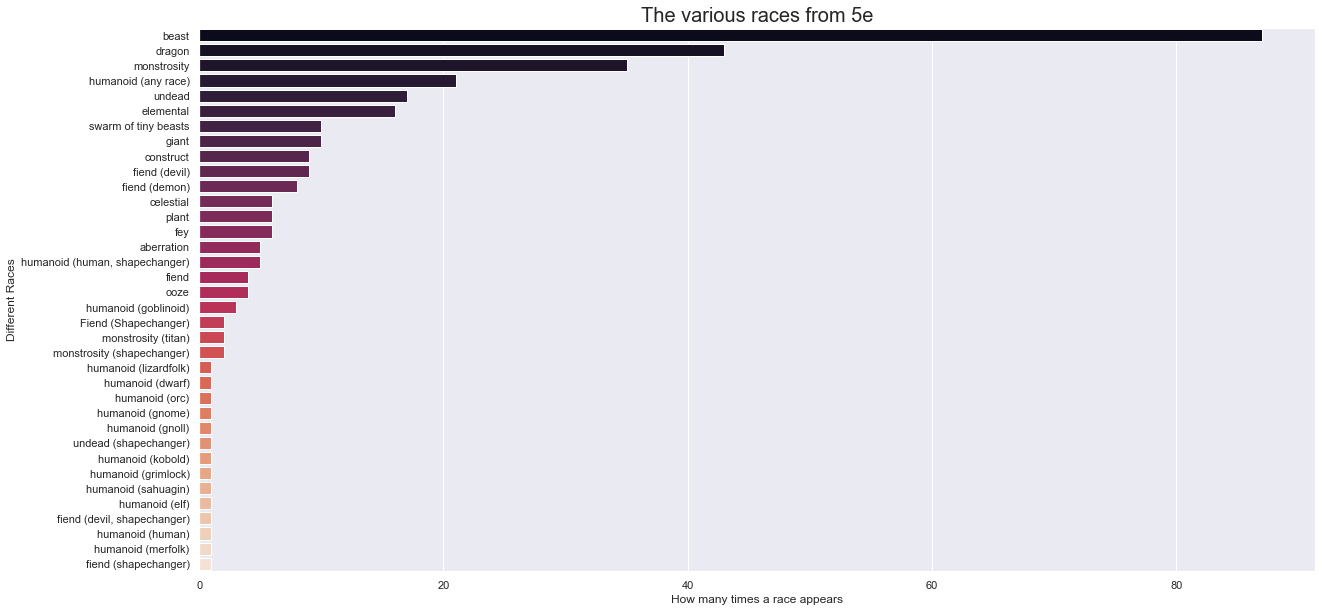

In [86]:
 
different_races_count = dnd['Race'].value_counts()
different_races = dnd['Race'].value_counts().keys()

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(ax=ax, x=different_races_count, y=different_races, 
            data=dnd,
            palette="rocket")
plt.title('The various races from 5e', fontsize=20)
plt.xlabel('How many times a race appears')
plt.ylabel('Different Races')
plt.show()

Even if we combined all of the humanoid variants, the number of Beasts surpasses all other individual races by double. Let's try and combine the races into fewer categories.

In [87]:
# combine all races to their main categories so the data looks more in sync. 
dnd['Race'] = dnd['Race'].apply(lambda x: x.split(' ')[0])

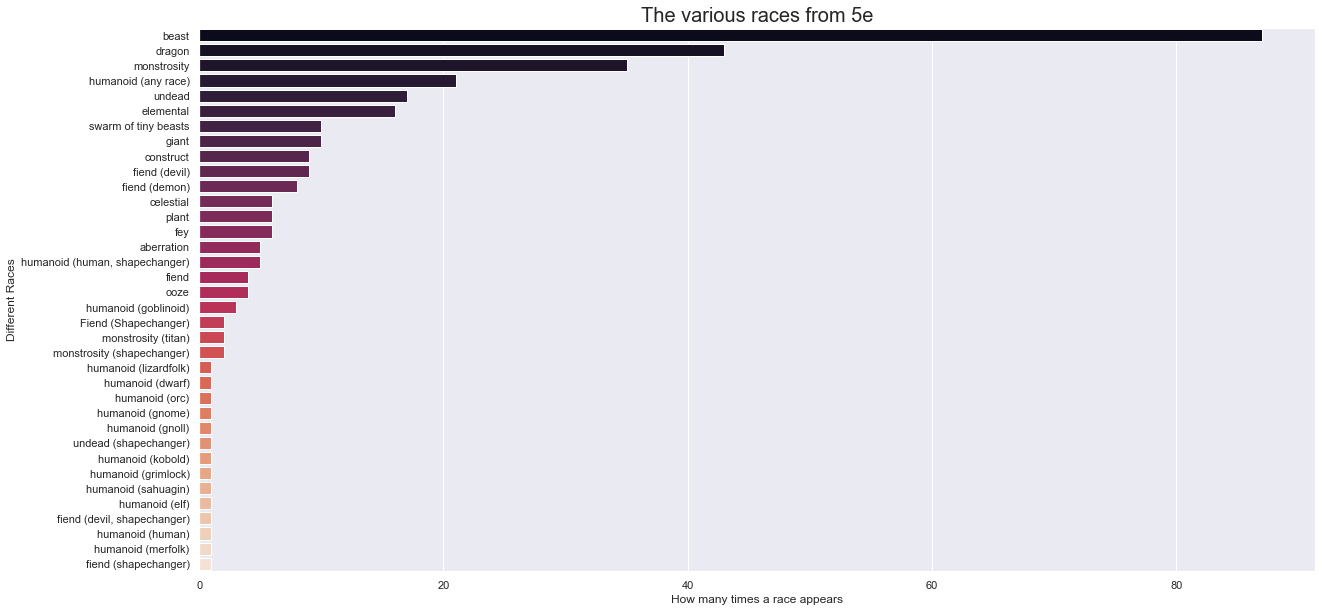

In [88]:
 
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(ax=ax, x=different_races_count, y=different_races, 
            data=dnd, 
            palette="rocket")
plt.title('The various races from 5e', fontsize=20)
plt.xlabel('How many times a race appears')
plt.ylabel('Different Races')

# plt.savefig('graphs/races_of_5e.png', bbox_inches = 'tight', edgecolor='w')
plt.show()

As we can see from the chart beasts are the most prevalent race in 5e, with Dragons, Humanoids (of varying types), and Monstrosities making up the next bulk of monsters.

## Is there any connection between monster type and alignment?

In [89]:
# get an idea for which alignments we are looking at in the data
dnd['Alignment'].value_counts()

Unaligned                                   128
Chaotic Evil                                 44
Lawful Evil                                  37
Neutral Evil                                 28
Neutral                                      19
Lawful Good                                  19
Any Alignment                                15
Chaotic Good                                 12
Neutral Good                                  6
Any Non-good Alignment                        4
Chaotic Neutral                               3
Lawful Neutral                                3
Any Non-lawful Alignment                      2
Any                                           1
Neutral Good (50%) Or Neutral Evil (50%)      1
Any Chaotic Alignment                         1
Any Evil Alignment                            1
Name: Alignment, dtype: int64

There are 9 alignments (and unaligned) that we care about, so let's take a look at just the basic alignments

In [90]:
# creating a list of the alignments we care to look over.
alignments = ['Chaotic Evil', 'Neutral Evil','Lawful Evil',
              'Chaotic Neutral','Neutral','Lawful Neutral', 
              'Chaotic Good', 'Neutral Good', 'Lawful Good',
              'Unaligned']

# this function will create a new column of 0/1 values so we narrow down our alignments with a true/false statement
dnd['True Alignment'] = dnd['Alignment'].apply(lambda alignment: 1 if alignment in alignments else 0)
dnd.head()

,Name,Size,HP,Armor,Race,Alignment,True Alignment
0,Aboleth,Large,135,17,aberration,Lawful Evil,1
1,Acolyte,Medium,9,10,humanoid,Any Alignment,0
2,Adult Black Dragon,Huge,195,19,dragon,Chaotic Evil,1
3,Adult Blue Dragon,Huge,225,19,dragon,Lawful Evil,1
4,Adult Brass Dragon,Huge,172,18,dragon,Chaotic Good,1


We are using a horizontal bargraph just for visualization because of how this material looks, even though a vertical bar group is best practice. 

In [91]:
# Use pd.Categorical to manually order the Size series instead of allowing for an alphabetical order
dnd['Alignment'] = pd.Categorical(dnd['Alignment'], categories=alignments, ordered=True)


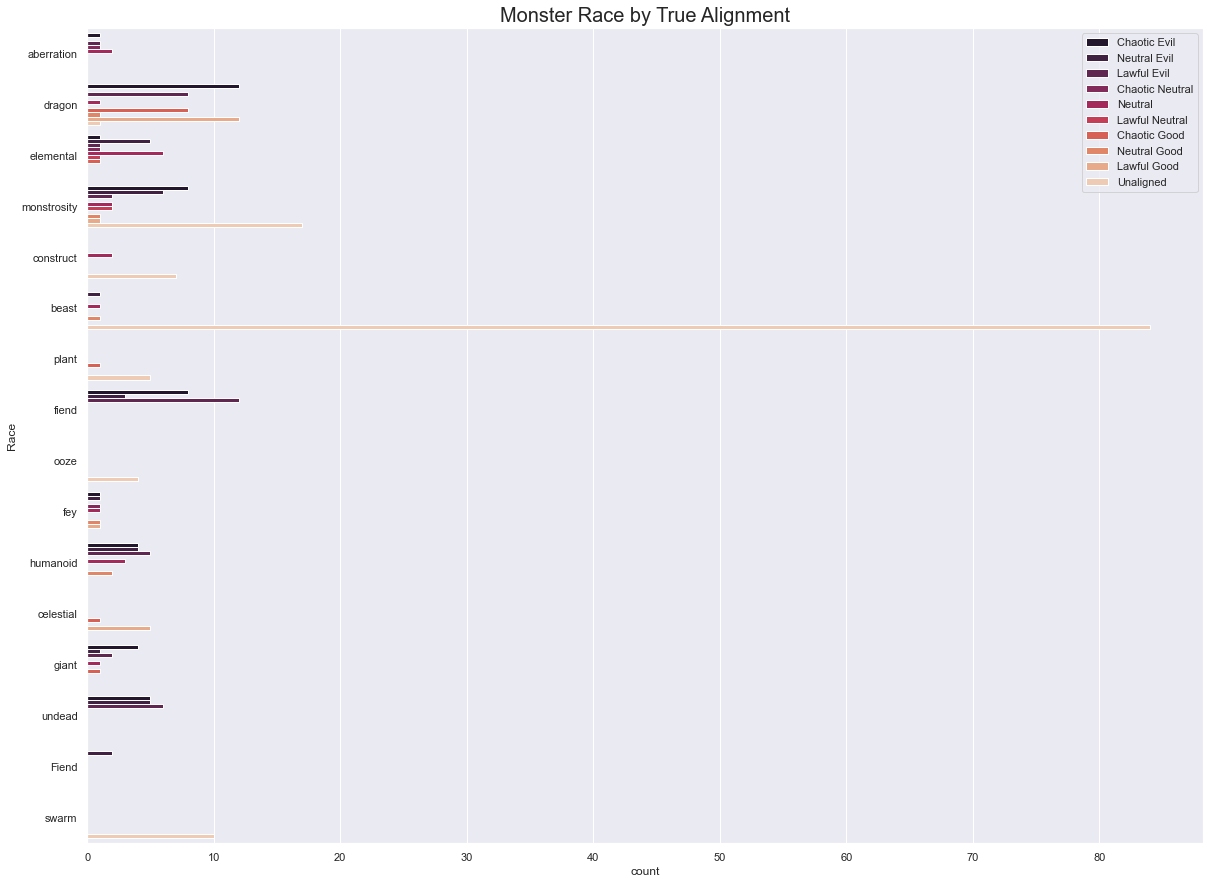

In [92]:
true_alignments = dnd[dnd['True Alignment'] == 1]

fig, ax = plt.subplots(figsize=(20,15))
sns.countplot(y=true_alignments['Race'], 
              hue=true_alignments['Alignment'], palette="rocket")
plt.title('Monster Race by True Alignment', fontsize=20)
legend = plt.legend()
# plt.savefig('graphs/monster_Race_by_alignment.png', bbox_inches = 'tight', edgecolor='w')
plt.show()

Beasts look to fall mostly in the unaligned category which seems to make sense. We can take a closer look at some of the other races with more variety.

## What does the spread of alignment look like for an individual monster race?

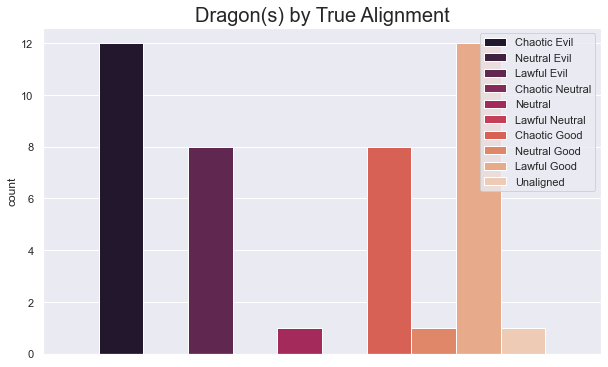

In [93]:
# create a function for looking at aligntment in individual races
def check_alignment(race):
    race = race.lower()
    single_race = true_alignments[true_alignments['Race']==race]

    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=single_race['Race'], 
                  hue=single_race['Alignment'], palette='rocket')
    plt.title(f'{race.capitalize()}(s) by True Alignment', fontsize=20)
    legend = plt.legend()
    plt.xticks(visible=False)
    plt.xlabel("")
    plt.savefig(f'graphs/{race}_alignment.png', bbox_inches = 'tight', edgecolor='w')
    plt.show()

check_alignment('dragon')

Dragons seem to have a variety, but also a dichotomy between good and evil. 

I would like to create a heatmap that follows a 3x3 grid to make the iconic alignment map. This is definitely a future project if possible, but after spending some time researching, this might be out of reach. 

<AxesSubplot:xlabel='Alignment', ylabel='Race'>

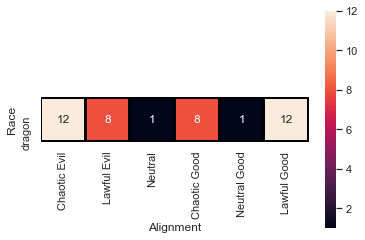

In [94]:
# creating a list of the alignments we care to look over.
alignments_grid = ['Chaotic Evil', 'Neutral Evil','Lawful Evil',
              'Chaotic Neutral','Neutral','Lawful Neutral', 
              'Chaotic Good', 'Neutral Good', 'Lawful Good']


# this function will create a new column of 0/1 values so we narrow down our alignments with a true/false statement
dnd['Alignment Grid'] = dnd['Alignment'].apply(lambda alignment: 1 if alignment in alignments_grid else 0)
dnd

true_alignments_grid = dnd[dnd['Alignment Grid'] == 1.0]
true_alignments_grid
true_alignments_grid[(true_alignments_grid['Race'] == 'dragon') & (true_alignments_grid['Alignment'] != 'Unaligned')].Alignment.value_counts()

substring='Unaligned'
filter=true_alignments_grid['Alignment'].str.contains(substring)

filtered_df = true_alignments_grid[~filter]
df=filtered_df[['Race', 'Alignment']]

counts = df.groupby(['Race', 'Alignment'], observed=True).size().reset_index(name='Count')
counts
heat_dnd = counts[counts['Race'] == 'dragon']
heat_dnd

pivot_dnd = heat_dnd.pivot(index='Race', columns='Alignment', values='Count').fillna(0)
sns.heatmap(pivot_dnd, square=True, annot=True, linewidth=2, cmap='rocket', linecolor='black')


Can't quite get the results I'm looking for here. 

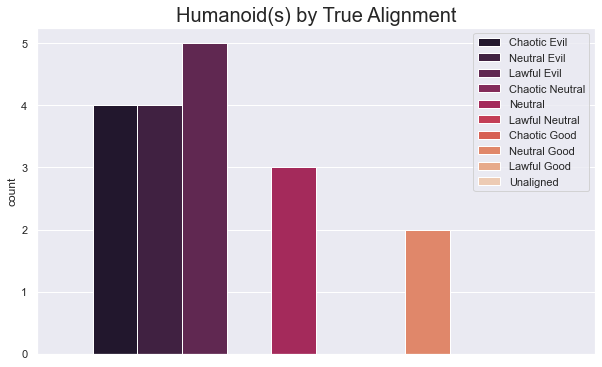

In [95]:
check_alignment('humanoid')

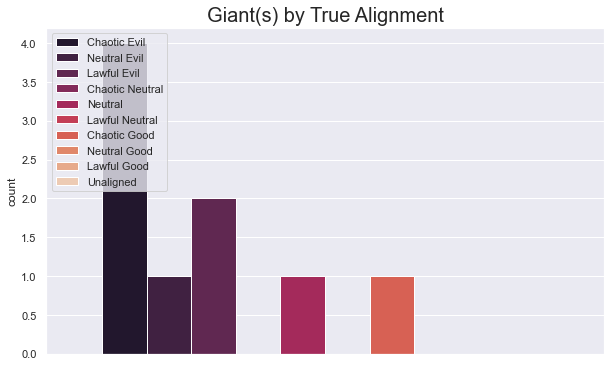

In [96]:
check_alignment('giant')

It seems like humanoids are mostly neutral or evil, which makes sense since most player characters are going to be the opposite. 

## Does monster size impact hit point amounts?

In [97]:
monster_size_and_hp = dnd[['Size', 'HP']]
monster_size = monster_size_and_hp['Size']
monster_hp = monster_size_and_hp['HP']

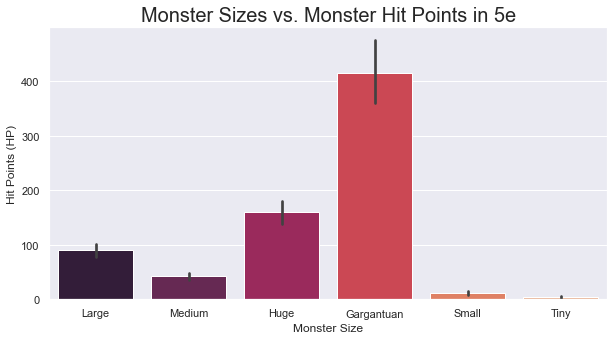

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y=monster_hp, x=monster_size, 
            data=monster_size_and_hp,
            palette='rocket')
plt.title('Monster Sizes vs. Monster Hit Points in 5e', fontsize=20)
plt.ylabel('Hit Points (HP)')
plt.xlabel('Monster Size')
# plt.savefig('graphs/monster_size_v_monster_hp.png', bbox_inches = 'tight', edgecolor='w')
plt.show()

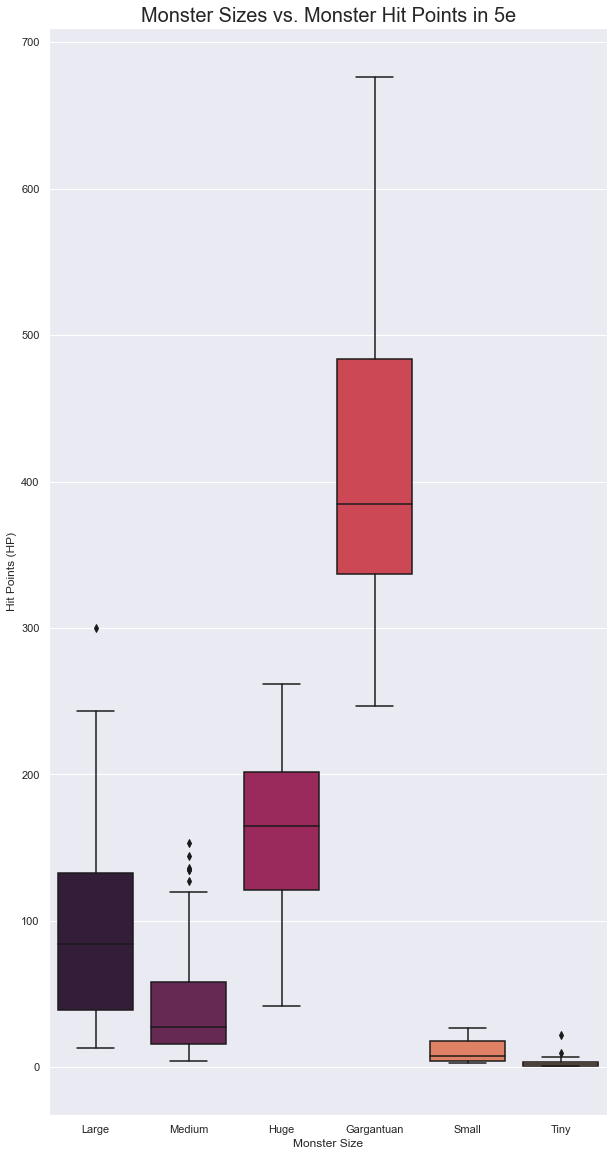

In [99]:
fig, ax = plt.subplots(figsize=(10,20))
sns.boxplot(y=monster_hp, x=monster_size, 
            data=monster_size_and_hp,
            palette='rocket')
plt.title('Monster Sizes vs. Monster Hit Points in 5e', fontsize=20)
plt.ylabel('Hit Points (HP)')
plt.xlabel('Monster Size')
plt.savefig('graphs/monster_size_v_monster_hp_box.png', bbox_inches = 'tight', edgecolor='w')
plt.show()

In [100]:
# finding the largest HP unit in a given monster size category
def find_monster_in_size_with_max_hp(size):
    df = dnd[monster_size==size.capitalize()]
    return df.loc[df['HP'] == df['HP'].max()]['Name'].values[0]
    # dnd[dnd['HP'] == dnd['HP'].max()]['Name'].values[0]

find_monster_in_size_with_max_hp('Gargantuan')

'Tarrasque'

Based off the chart above, the average HP for a monster is definitely associated with its size. 

## Does a monster’s armor class have a correlation with its hit points?

In [101]:
# Use pd.Categorical to manually order the Size series instead of allowing for an alphabetical order

dnd['Size'] = pd.Categorical(dnd['Size'], categories=['Gargantuan', 'Huge','Large','Medium','Small','Tiny'], ordered=True)
marker_size = dnd.sort_values('Size', ascending=True)

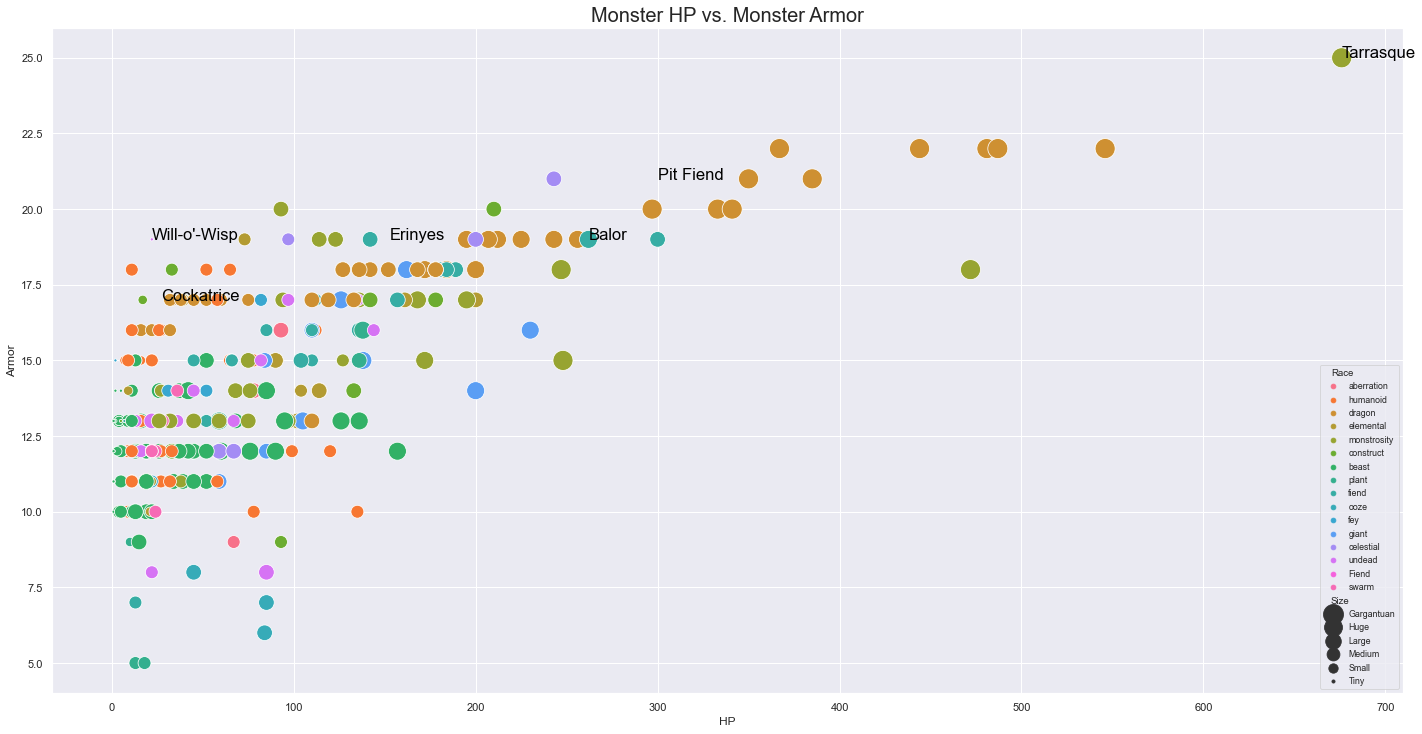

In [102]:
monster_hp = dnd['HP']
monster_armor = dnd['Armor']

MONSTER_SYMBOLS = []



fig,ax = plt.subplots(figsize=(20,10))
sns.set_context('paper')

sns.scatterplot(x=monster_hp, y=monster_armor, hue=dnd['Race'], size=marker_size['Size'], sizes=(10, 400))

# Put the name of the monster that fits the max HP and Max armor for each size next to its marker
plt.text(monster_hp[dnd['Size']=='Tiny'].max(),monster_armor[dnd['Size']=='Tiny'].max(),find_monster_in_size_with_max_hp('Tiny'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.text(monster_hp[dnd['Size']=='Small'].max(),monster_armor[dnd['Size']=='Small'].max(),find_monster_in_size_with_max_hp('Small'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.text(monster_hp[dnd['Size']=='Medium'].max(),monster_armor[dnd['Size']=='Medium'].max(),find_monster_in_size_with_max_hp('Medium'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.text(monster_hp[dnd['Size']=='Large'].max(),monster_armor[dnd['Size']=='Large'].max(),find_monster_in_size_with_max_hp('Large'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.text(monster_hp[dnd['Size']=='Huge'].max(),monster_armor[dnd['Size']=='Huge'].max(),find_monster_in_size_with_max_hp('Huge'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.text(monster_hp[dnd['Size']=='Gargantuan'].max(),monster_armor[dnd['Size']=='Gargantuan'].max(),find_monster_in_size_with_max_hp('Gargantuan'), color='black', fontsize='xx-large', fontvariant='small-caps')
plt.tight_layout()
ax.set_title('Monster HP vs. Monster Armor', fontsize=20)
# plt.savefig('graphs/monster_hp_v_monster_armor.png', bbox_inches = 'tight', edgecolor='w')
plt.show()

Let's separate all monster sizes and see how their plots look? What can we glean?

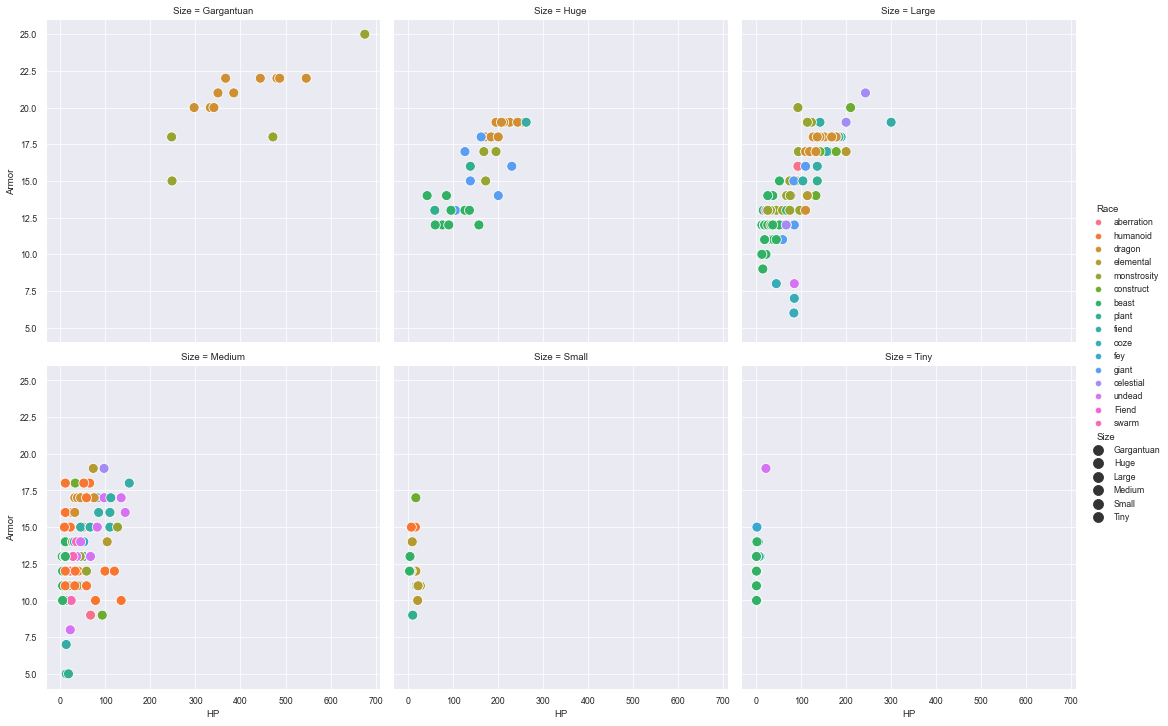

In [103]:
sns.relplot(
    x=monster_hp, y=monster_armor, hue=dnd['Race'],
      col=dnd['Size'], col_wrap=3,
      size=marker_size['Size'], sizes=(100, 100))

# plt.savefig('graphs/monster_hp_v_monster_armor_across_sizes.png', bbox_inches = 'tight', edgecolor='w')

plt.show()


It seems Medium size and Large size have the widest spread. The HP values for Tiny and Small are so consistent. 

## Suggestions to the Dungeons and Dragons creators

1. Based off findings, Beasts make up a huge portion of the monster races. I believe it would be best to create more official monsters from other races. The reason being that it promotes more campaign settings, especially for early levels. 

2. Another area of focus would be the bring in more "good" alignments for monster races. The data shows that Humanoids are mostly evil and neutral. Some more guidance for players who come up across lawful good NPCs would be interesting. 

3. Last suggestion would be to add a few more variations for HP vs. Monster Size. Right now it's pretty proportional, as size goes up, HP goes up. It would be great to see some Tiny creatures with 20-50 HP just to give players a hard time. Something that is super hard to lock down, but maybe not super powerful. 

## More Exploration outside of this discovery for a later date. 

We can take a look at what the most used combination of HP and Armor out of all Monster races.

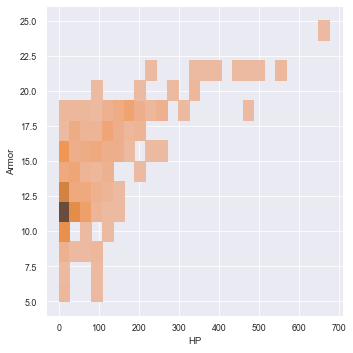

In [104]:
sns.displot(
    dnd, x=monster_hp, y=monster_armor)
plt.show()

c:\Users\dmm46\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'observed'
  cset = contour_func(


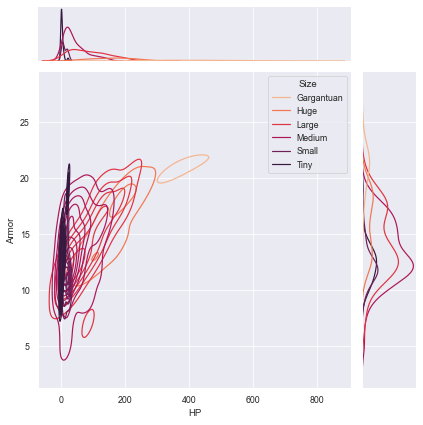

In [105]:

sns.jointplot(
    data=dnd, x=monster_hp, y=monster_armor, hue=dnd['Size'], kind='kde', observed=True)
plt.show()

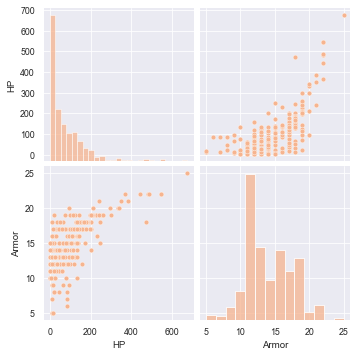

In [106]:
sns.pairplot(dnd[['HP', 'Armor', ]])

## Playing with probability

In [107]:
dnd.head()
dnd['Size'].value_counts(normalize=True)

Medium        0.395062
Large         0.317901
Huge          0.098765
Tiny          0.074074
Small         0.067901
Gargantuan    0.046296
Name: Size, dtype: float64

In [108]:
print(len(dnd.index))
print(len(dnd.loc[dnd['Size'] == 'Tiny'].index))

len(dnd.loc[dnd['Size'] == 'Tiny']) / len(dnd)

324
24


0.07407407407407407

In [109]:
p_Size = dnd[dnd['Size'] == 'Tiny'].shape[0]/df.shape[0]
p_Size

0.14035087719298245

In [110]:
p_Armor = dnd[dnd['Armor'] > 20].shape[0]/df.shape[0]
p_Armor

0.05847953216374269

In [111]:
dnd.sample(1)

,Name,Size,HP,Armor,Race,Alignment,True Alignment,Alignment Grid
41,Bearded Devil,Medium,52,13,fiend,Lawful Evil,1,1.0


In [112]:
dnd['Armor']

0      17
1      10
2      19
3      19
4      18
       ..
319    18
320    18
321    18
322    17
323     8
Name: Armor, Length: 324, dtype: int64

### What's the probability you select a row that is sized Tiny and armor is > 12?

In [113]:
p_Size_and_Armor = dnd[(dnd['Size'] == 'Tiny') & (dnd['Armor'] > 12)].shape[0]/dnd.shape[0]
p_Size_and_Armor

0.037037037037037035

In [114]:
p_Size * p_Armor

0.008207653637016516

In [115]:
p_Size_and_Armor == p_Size * p_Armor

False

### Looking at conditional probability

In [116]:
tiny_size = dnd[dnd['Size'] == 'Tiny']
tiny_size['Armor'].value_counts(normalize=True)

13    0.333333
11    0.208333
12    0.166667
10    0.125000
14    0.083333
19    0.041667
15    0.041667
Name: Armor, dtype: float64

### Bayesian

P(h|e)=[P(e|h)P(h)]/P(e) 

In [117]:
TINY = (dnd['Size'] == 'Tiny')
ARMOR = (dnd['Armor'] == 12)

p_tiny = dnd[TINY].shape[0] / dnd.shape[0]
p_armor_given_tiny = len(dnd[TINY]['Armor']) / dnd[TINY].shape[0]
p_armor = dnd[ARMOR].shape[0]/dnd.shape[0]

p_tiny_given_armor = (p_tiny * p_armor_given_tiny) / (p_armor)
print(f'P(Tiny|Armor) = {p_tiny_given_armor}')


P(Tiny|Armor) = 0.39344262295081966


In [118]:
armor = dnd[ARMOR]
armor_props = armor['Size'].value_counts(normalize=True)
print(armor_props.index[0], armor_props[0])

Medium 0.4262295081967213


Not quite correct, will need to play with this more. 

## A monster's health and size questions

H0: A monster's size has no impact on its health pool
HA: A monster's size will effect its health pool with positive correlation

In [119]:
dnd_look = dnd[['Size', 'HP']]

# dnd_look['Size'] = pd.Categorical(dnd_look['Size'], categories=['Gargantuan', 'Huge','Large','Medium','Small','Tiny'], ordered=True)
dnd_look

,Size,HP
0,Large,135
1,Medium,9
2,Huge,195
3,Huge,225
4,Huge,172
...,...,...
319,Large,136
320,Large,178
321,Large,168
322,Large,133


In [120]:
dnd_look.groupby('Size').agg(['mean', 'std'])

HP            
                  mean         std
Size                              
Gargantuan  414.666667  121.225096
Huge        159.312500   62.296605
Large        89.815534   60.696084
Medium       42.539062   35.439402
Small        11.500000    7.860389
Tiny          3.416667    4.643056

In [121]:
print('Small monsters')
dnd_small = dnd_look[dnd_look['Size'] =='Small']
display(dnd_small.describe())
print('\n------------------------\n')

print('Huge monsters')
dnd_huge = dnd_look[dnd_look['Size'] =='Huge']
display(dnd_huge.describe())

Small monsters


,HP
count,22.000000
mean,11.500000
std,7.860389
min,3.000000
25%,4.250000
50%,8.000000
75%,17.750000
max,27.000000



------------------------

Huge monsters


,HP
count,32.000000
mean,159.312500
std,62.296605
min,42.000000
25%,120.750000
50%,165.000000
75%,201.750000
max,262.000000


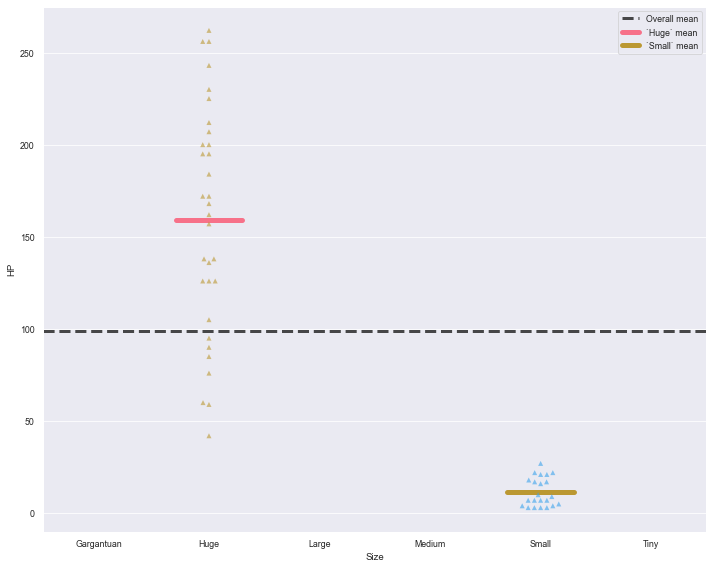

In [122]:
f, ax = plt.subplots(figsize=(10, 8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Select only two areas
selection_mask = (dnd_look['Size'] == 'Small') | (dnd_look['Size'] == 'Huge')
data_subset = dnd_look[selection_mask]

# Data Points
ax = sns.swarmplot(
    data=data_subset,
    x="Size",
    y="HP",
    ax=ax,
    alpha=0.6, 
    marker='^',
    palette=colors
)

ax.axhline(
    data_subset['HP'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

# Look at each specifc group (by area)
sizes = data_subset['Size'].unique()
for i, size in enumerate(sizes):
    mean = dnd_look[dnd_look['Size']==size]['HP'].mean()
    # Make these lines short and near each group
    xmin = 1/len(sizes) * i + 0.2
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{size}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
    
ax.legend()
plt.tight_layout();
plt.show()

## Performing two-sample t-test

In [123]:
print(stats.ttest_ind(dnd_small['HP'], dnd_huge['HP']))
print(stats.ttest_ind(dnd_small['HP'], dnd_huge['HP'], equal_var=False))

Ttest_indResult(statistic=-11.0364063880537, pvalue=3.0926121198544082e-15)
Ttest_indResult(statistic=-13.26937863522582, pvalue=1.1851220473020993e-14)


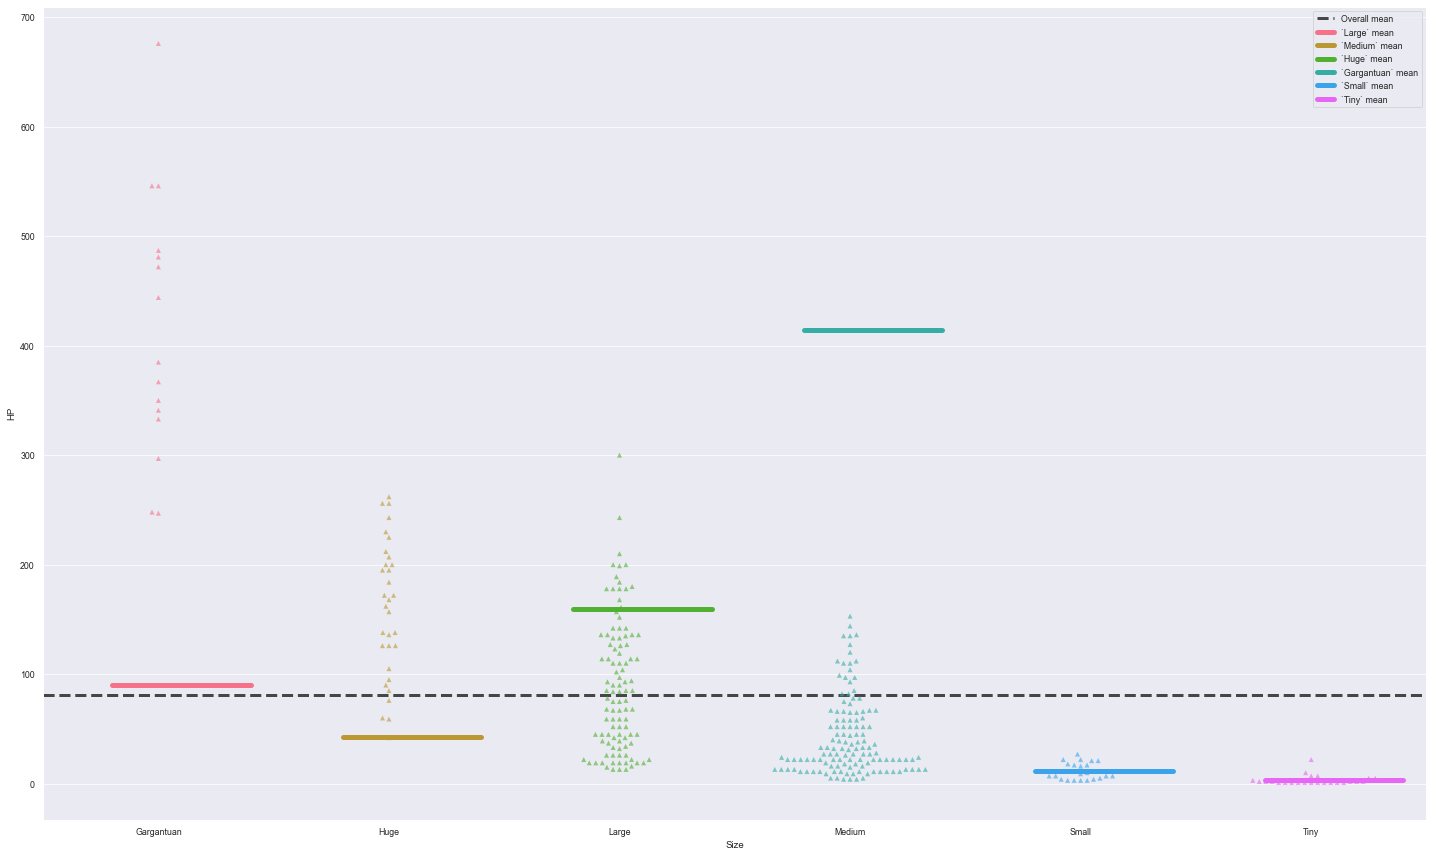

In [124]:
f, ax = plt.subplots(figsize=(20, 12))

# Use specific set of colors
colors = sns.color_palette('husl')

# Data Points
ax = sns.swarmplot(
    data=dnd_look,
    x="Size",
    y="HP",
    ax=ax,
    alpha=0.6, 
    marker='^',
    palette=colors
)

ax.axhline(
    dnd_look['HP'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

# Look at each specifc group (by area)
sizes = dnd_look['Size'].unique()
for i, size in enumerate(sizes):
    mean = dnd_look[dnd_look['Size']==size]['HP'].mean()
    # Make these lines short and near each group
    xmin = 1/len(sizes) * i + 0.05
    xmax = xmin + 0.1
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{size}` mean',
        lw=5, ls='-', color=colors[i]
    ) 
    
ax.legend()
plt.tight_layout();
plt.show()

## One-Way ANOVA

In [125]:
alpha = 0.01

### getting the values of each group

In [126]:
gargantuan = dnd_look[dnd_look['Size'] == 'Gargantuan']['HP'].values
huge = dnd_look[dnd_look['Size'] == 'Huge']['HP'].values
large = dnd_look[dnd_look['Size'] == 'Large']['HP'].values
medium = dnd_look[dnd_look['Size'] == 'Medium']['HP'].values
small = dnd_look[dnd_look['Size'] == 'Small']['HP'].values
tiny = dnd_look[dnd_look['Size'] == 'Tiny']['HP'].values

In [127]:
gargantuan

array([367, 481, 297, 444, 350, 546, 385, 546, 487, 333, 341, 472, 247,
       248, 676], dtype=int64)

In [128]:
groups = {'Gargantuan': gargantuan, 'Huge': huge, 'Large': large,
          'Medium': medium, 'Small': small, 'Tiny': tiny}

In [129]:
# Note I'm simply unpacking the iterator instead of typing each out
result = stats.f_oneway(*groups.values())
f_stat, p = result
# Printing out the result just to show what it looks like
result

F_onewayResult(statistic=170.53271882524848, pvalue=9.633889937993082e-88)

In [130]:
groups = {'Large': large,
          'Medium': medium, 
          'Small': small}

# Note I'm simply unpacking the iterator instead of typing each out
result = stats.f_oneway(*groups.values())
f_stat, p = result

print(result)

conclusion = 'significant' if p < alpha else 'not significant'

print(f'''
The difference between the different groups was {conclusion} for a significance
level of {alpha}.
''')

F_onewayResult(statistic=42.42837299524654, pvalue=1.364958688469479e-16)

The difference between the different groups was significant for a significance
level of 0.01.

